In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

In [ ]:
# import calibration curves from "acetone_cal.ipynb"
%run acetone_cal.ipynb

In [3]:
# integrated bimolecular rate equation
def c_second(x,a,b,k):
  return (a - b) * ( 1 / ( 1 - b/a * np.exp( - k * x * (a - b) ) ) - 1 )

In [4]:
# unimolecular rate equation
def exp(x,b,k):
  return b * np.exp(- k * x)

In [5]:
with open('ac_50_4.csv') as f:
    reader = csv.reader(f)
    data = list(reader)

In [6]:
xs = np.array(data).astype(float)[:,0]

In [7]:
data = np.array(data).astype(float)[:,1]

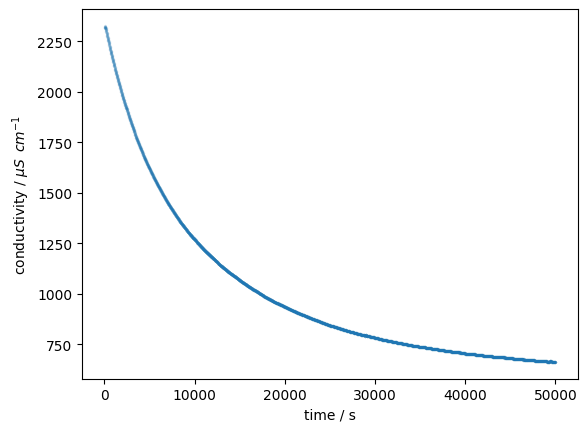

In [8]:
plt.scatter(xs,data,s=2,alpha=0.1,marker='o')
plt.xlabel('time / s')
plt.ylabel('conductivity / $\mu S \hspace{.5} cm^{-1}$')
plt.show()

In [9]:
vol = 30
m_bncl = 0.0765
vol += m_bncl / 1.1 # account for volume of BnCl
n_ki = 0.1025 / 166.0028
n_bncl = m_bncl / 126.58
b = 1000 * n_ki / vol
a = 1000 * n_bncl / vol

In [10]:
a

0.020098770013314417

In [11]:
b

0.0205343797255776

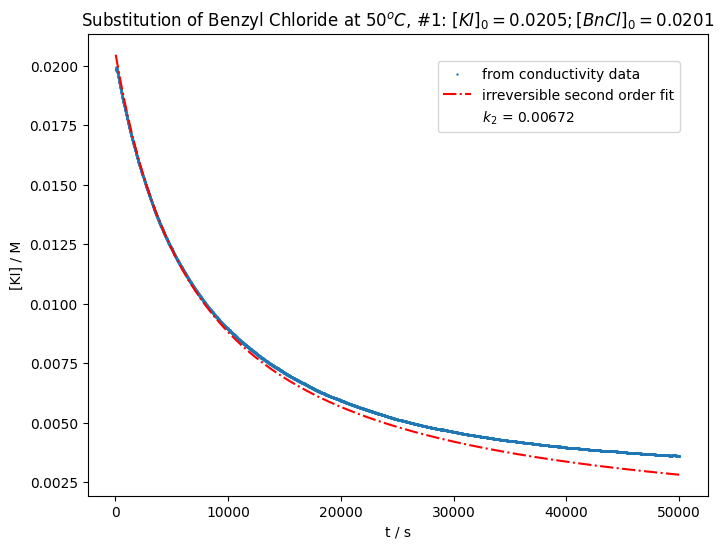

In [12]:
x = xs
y = np.array( inv_quad_p(data,*popt50n_i) )

plt.figure(figsize=(8,6))
plt.scatter(x,y,s=.5,alpha=1,marker='o',label='from conductivity data')

# Bimolecular fit on first 10000s of reaction
popt, pcov = curve_fit( lambda x, k: c_second(x,a,b,k), x[:1000] , y[:1000] , p0=[0.0005])
k2 = popt[0]
plt.plot(x,c_second(x,a,b,k2),'r-.',label='irreversible second order fit')


plt.plot([],[],alpha=0,label=f'$k_2$ = {k2:.5f}')

plt.xlabel('t / s')
plt.ylabel('[KI] / M')
plt.title(f'Substitution of Benzyl Chloride at $50^oC$, #1: $[KI]_0 = {b:.4f}; [BnCl]_0 = {a:.4f}$')
plt.legend(borderaxespad=2)

plt.show()

In [13]:
d_eq = y[0] - y[-1]

In [14]:
a - d_eq

0.003840252225454862

In [15]:
b - d_eq

0.004275861937718044

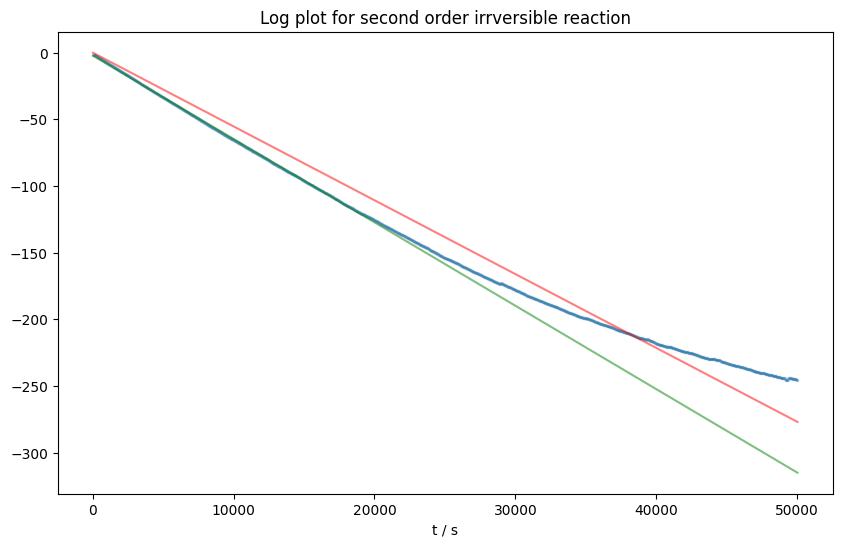

In [16]:
s_y = np.log( a/b * y / ((a - b) + y) ) / (a - b)
plt.figure(figsize=(10,6))
plt.scatter(x,s_y,s=2,alpha=0.05,marker='o')

# straight line fit for whole rxn
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(x.reshape(-1,1),s_y.reshape(-1,1))
m = lin_reg.coef_[0][0]
plt.plot(x,(m*x),'r-',alpha=0.5)

# straight line for start of rxn
lin_reg2 = LinearRegression(fit_intercept=True)
lin_reg2.fit(x[:2000].reshape(-1,1),s_y[:2000].reshape(-1,1))
m2 = lin_reg2.coef_[0][0]
int2 = lin_reg2.intercept_[0]
plt.plot(x,(m2*x + int2),'g-',alpha=0.5)

plt.title('Log plot for second order irrversible reaction')
plt.xlabel('t / s')


plt.show()

In [17]:
m

-0.005537782421719106

In [18]:
m2

-0.006254987850730862

In [19]:
k2

0.006720157461989816

In [20]:
IR_679 = pd.read_csv('acetone_50_easy_12_ir_679.txt',sep="\t")

In [21]:
ir_679 = np.array(IR_679[IR_679.columns[1]])

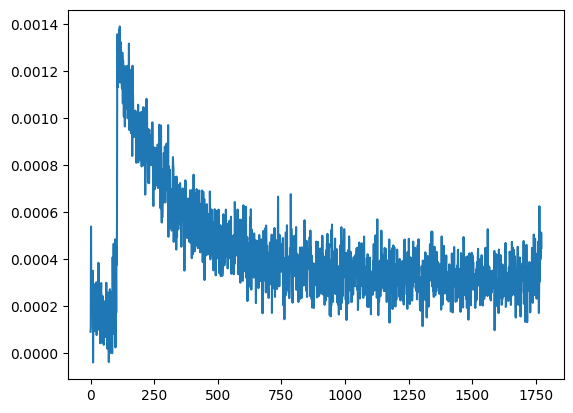

In [22]:
plt.plot(ir_679)

In [23]:
ir_clean_679 = ir_679[104:]

In [24]:
ir_xs = np.array(range(0,len(ir_clean_679)*30,30))

In [25]:
bncl_conc_ir_679 = (ir_clean_679 - int_679) / slope_679

In [26]:
ki_conc_ir_679 = b - (a - bncl_conc_ir_679)

In [39]:
# Smooth data with moving average
smooth_679 = np.convolve(ki_conc_ir_679[2:], np.ones(5)/5, mode='same')

## Other Peak

In [34]:
IR_1720 = pd.read_csv('acetone_50_easy_12_ir_1720.txt',sep="\t")

In [35]:
ir_1720 = np.array(IR_1720[IR_1720.columns[1]])

In [36]:
ir_1720 = ir_1720[104:]

In [37]:
# lets try some streching!!!
ir_end = np.mean(ir_1720[int(50000/30)-10:int(50000/30)])
ir_spread = ir_end - 0
cond_end = np.mean(y[4999:5000])
cond_spread = y[0] - cond_end
stretch = cond_spread / ir_spread
ir_1720 *= -stretch
ir_1720_mod = ir_1720 + y[0] - ir_1720[0]

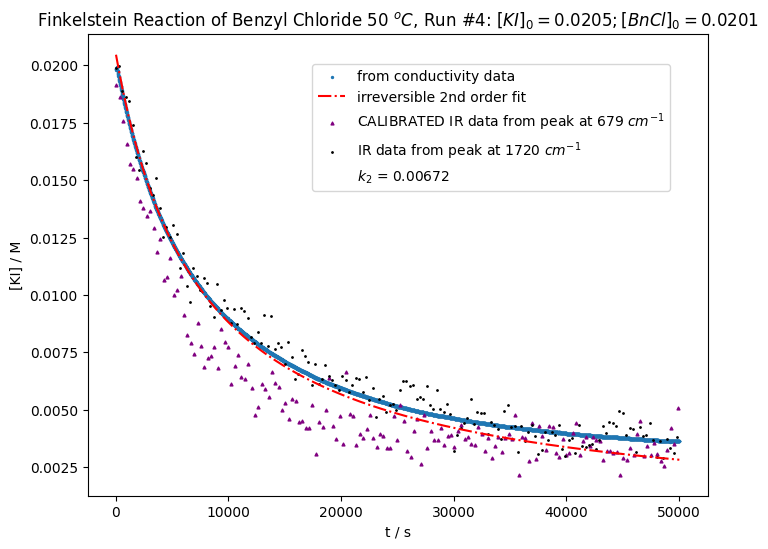

In [43]:
plt.figure(figsize=(8,6))

plt.scatter(x,y,s=2,alpha=1,marker='o',label='from conductivity data')

plt.plot(x,c_second(x,a,b,k2),'r-.',label='irreversible 2nd order fit')

# Uncomment to add IR data
plt.scatter(ir_xs[2::10],smooth_679[2::10],s=4,c='purple',marker='^',label='CALIBRATED IR data from peak at 679 $cm^{-1}$')

plt.scatter(ir_xs[::10],ir_1720_mod[::10],s=4,c='black',marker='.',label='IR data from peak at 1720 $cm^{-1}$')

plt.plot([],[],alpha=0,label=f'$k_2$ = {k2:.5f}')


plt.xlabel('t / s')
plt.ylabel('[KI] / M')
plt.title(f'Finkelstein Reaction of Benzyl Chloride 50 $^oC$, Run #4: $[KI]_0 = {b:.4f}; [BnCl]_0 = {a:.4f}$')
plt.legend(loc=1,bbox_to_anchor=(.95,.95))


plt.show()